In [121]:
import pandas as pd
import numpy as  np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing

In [269]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a week column and a hierarchical index (year, month, week, day, hour).
    For the daily-only data also add a hierarchical index (year, month, week, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    data = pd.DataFrame()
    df_local = []
    for file in glob.glob("./data/*"):
        df_file = pd.read_csv(file, delimiter=";")
        df_local.append(df_file)
    data = pd.concat(df_local, ignore_index=True)

    data.date = pd.to_datetime(data.date, format="%d.%m.%Y")
    data = data.sort_values("date")
    data = data.reset_index(drop=True)
    
    data["year"] = data.date.dt.year
    data["month"] = data.date.dt.month
    data["day"] = data.date.dt.day
    data["week"] = data.date.dt.isocalendar().week

    # Extracting the data for second dataset
    data2 = data[["date",'year', "month", "week", "day","precipType",  "precip"]]
    weather_data_daily = data2.set_index(["year", "month", "week", "day"])


    df_melted = pd.melt(data.drop(["precipType", "precip"], axis=1), id_vars=["date", 'year', "month", "week", "day"])
    attribute = [name[0] for name in df_melted.variable.str.split("_")[:]]
    hours = [name[1] for name in df_melted.variable.str.split("_")[:]]

    df_melted['attributes'] = attribute
    df_melted['hours'] = hours
    df_melted.hours = df_melted.hours.str.replace("h", "").astype(int)
  
    df_melted.drop(["variable"], axis=1, inplace=True)
    df_done = pd.pivot(df_melted, index=["year", "month", "week", "day", "hours", "date"], columns="attributes", values="value")
    df_final = df_done.reset_index().set_index(["year", "month", "week", "day", "hours"])
    df_final["airPressure"] = df_final["airPressure"].astype('float')
    df_final["temp"] = df_final["temp"].astype('float')
    df_final["hum"] = df_final["hum"].astype('int')
    df_final["windBeauf"] = df_final["windBeauf"].astype('int')
    df_final["skyCover"] = df_final["skyCover"].astype('int')

    weather_data = df_final

    return weather_data, weather_data_daily

In [270]:
df1, df2 = load_weather_data("./data")

In [271]:
df1

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

## Glava 2

In [272]:
df1.groupby(level=["year", "month"]).count().sum(axis=1).sort_values().idxmax()


(2013, 10)

## Glava 3


In [144]:
df_local = []
for file in glob.glob("./influenza/*"):
    print(file)
    df_file = pd.read_csv(file)
    df_local.append(df_file)

df = pd.concat(df_local, ignore_index=True)

./influenza/influenza_09-19.csv
./influenza/influenza_19-21.csv


In [145]:
yeat = [name[0] for name in df["Season Week"].str.split("/")[:]]
weeks = [val.split("_")[1] for val in [name[1] for name in df["Season Week"].str.split("/")[:]]]

In [146]:
df["year"] = yeat
df["week"] = weeks

df = df[pd.to_numeric(df['New Cases'], errors='coerce').notnull()]

In [147]:
df.year = df.year.astype(int)
df.week = df.week.astype(int)
df['New Cases'] = df['New Cases'].astype(int)

new_years = []
for index, row in df.iterrows():
    if (row.week < 25):
        new_years.append(row["year"] + 1)
    else:
        new_years.append(row["year"])
df["new_years"] = new_years

In [148]:
influenza = df.drop(["Season Week", "Margin", "year"], axis=1)
influenza = influenza.rename(columns={"New Cases":"weekly_infections", "new_years": "year"})

In [149]:
influenza = influenza.set_index(["year", "week"]).dropna(axis=1)

In [150]:
influenza.sort_values("weekly_infections", ascending=False).head(1).idxmax()[0]

(2017, 1)

In [151]:
influenza

weekly_infections
year week                   
2009 40                 6600
     41                 7100
     42                 7700
     43                 8300
     44                 8600
...                      ...
2021 5                  1400
     4                  1800
     3                  1800
     2                  1500
     1                  1300

[310 rows x 1 columns]

In [152]:
#sns.lineplot(x = df1.date, y = df1.airPressure)

In [153]:
df1.groupby(["year", "month", "week"]).mean()

attributes       airPressure        hum  skyCover      temp  windBeauf
year month week                                                       
2009 1     1      997.700000  70.500000  7.166667 -2.327273   2.333333
           2     1001.850000  78.523810  6.095238 -4.780952   2.095238
           3      997.333333  86.428571  8.476190 -3.119048   2.095238
           4      975.105000  76.666667  7.000000  3.471429   2.238095
           5      988.938889  83.666667  8.944444  0.655556   2.722222
...                      ...        ...       ...       ...        ...
2021 12    48     980.500000  74.533333  8.666667  4.400000   2.266667
           49     985.800000  82.809524  8.142857  1.580952   2.333333
           50    1003.905000  78.000000  8.809524  5.738095   3.142857
           51     991.819048  76.619048  6.857143  1.095238   2.380952
           52     988.040000  84.466667  7.866667  5.406667   2.200000

[812 rows x 5 columns]

<AxesSubplot:xlabel='week', ylabel='skyCover'>

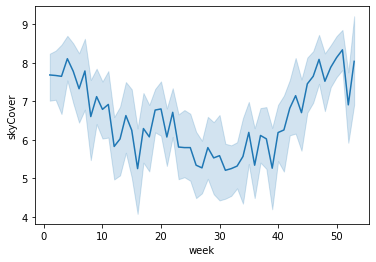

In [154]:
sns.lineplot(x = df1.groupby(["year", "month", "week"]).mean().reset_index().week, y = df1.groupby(["year", "month", "week"]).mean().reset_index().skyCover)

In [155]:
df_grouped = df1.groupby(["year", "week"]).mean()

In [156]:
df_grouped

attributes  airPressure        hum  skyCover      temp  windBeauf
year week                                                        
2009 1       997.700000  70.500000  7.166667 -2.327273   2.333333
     2      1001.850000  78.523810  6.095238 -4.780952   2.095238
     3       997.333333  86.428571  8.476190 -3.119048   2.095238
     4       975.105000  76.666667  7.000000  3.471429   2.238095
     5       988.890476  84.238095  9.095238  0.414286   2.714286
...                 ...        ...       ...       ...        ...
2021 49      985.800000  82.809524  8.142857  1.580952   2.333333
     50     1003.905000  78.000000  8.809524  5.738095   3.142857
     51      991.819048  76.619048  6.857143  1.095238   2.380952
     52      988.040000  84.466667  7.866667  5.406667   2.200000
     53      986.162500  91.888889  9.888889  1.900000   1.666667

[682 rows x 5 columns]

In [157]:
plt.figure(figsize=(10,10))
sns.scatterplot(df_grouped.date.dt.year, df_grouped.skyCover, hue=df_grouped.date.dt.month, legend="full", palette=sns.color_palette("Spectral", as_cmap=True), s=60)
plt.legend(loc='lower left')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'date'

<Figure size 720x720 with 0 Axes>

In [158]:
df1[df1.windDir.isna()]

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    2   7     2009-01-02        999.6   67        10  -3.0   
           2    10  7     2009-01-10       1007.0   88         4 -10.6   
     3     11   15  7     2009-03-15        993.7   84        10   5.5   
           13   27  7     2009-03-27        981.9   82         8   4.5   
     4     16   13  7     2009-04-13        985.2   78         0  10.4   
...                              ...          ...  ...       ...   ...   
2021 10    40   10  7     2021-10-10       1002.6   88         5   3.6   
           41   17  7     2021-10-17        997.4   96         5   2.4   
           42   19  7     2021-10-19       1001.8   97         7   4.7   
           43   27  19    2021-10-27       1002.2   84         0   8.5   
     11    47   24  7     2021-11-24       1001.4   93         7  -0.6   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    2   7              0     NaN  
           2    10  7              0     NaN  
     3     11   15  7              0     NaN  
           13   27  7              0     NaN  
     4     16   13  7              0     NaN  
...                              ...     ...  
2021 10    40   10  7              0     NaN  
           41   17  7              0     NaN  
           42   19  7              0     NaN  
           43   27  19             0     NaN  
     11    47   24  7              0     NaN  

[184 rows x 7 columns]

In [273]:
df_lists = []

for id, row in df1.reset_index()[df1.reset_index().windDir.isna()].iterrows():
    mini_frame = []
    mini_frame.append(df1[df1.date == row.date])
    for i in range(1, 3):
      plus_day = df1[df1.date == row.date + datetime.timedelta(i)]
      minus_day = df1[df1.date == row.date - datetime.timedelta(i)]
      mini_frame.append(plus_day) 
      mini_frame.append(minus_day)
    df_lists.append(pd.concat(mini_frame))

    

In [274]:
def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    # TODO better description
    # check out datetime.timedelta! 
    df_list = []

    for id, row in df.reset_index()[df.reset_index()[column].isna()].iterrows():
        mini_frame = []
        mini_frame.append(df[df.date == row.date])
        for i in range(1, delta_days + 1):
          plus_day = df[df.date == row.date + datetime.timedelta(i)]
          minus_day = df[df.date == row.date - datetime.timedelta(i)]
          mini_frame.append(plus_day) 
          mini_frame.append(minus_day)
        df_list.append(pd.concat(mini_frame).sort_values("date"))

    return df_list


In [275]:
df1

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

In [276]:
lists_air_pressure = get_data_around_missing(df1, 'airPressure')

In [277]:
lists_air_pressure

[attributes                      date  airPressure  hum  skyCover  temp  \
 year month week day hours                                                
 2009 1     1    3   7     2009-01-03       1002.7   83         3  -4.8   
                     14    2009-01-03       1000.0   70         5   NaN   
                     19    2009-01-03        998.1   70         1  -3.9   
                 4   7     2009-01-04        993.4   75         5  -3.8   
                     14    2009-01-04        991.0   62         9  -0.2   
                     19    2009-01-04        990.1   63         9  -0.5   
            2    5   7     2009-01-05        988.4   64         9  -0.7   
                     14    2009-01-05          NaN   76        10  -0.6   
                     19    2009-01-05        992.3   80        10  -1.3   
                 6   7     2009-01-06        996.7   87        10  -4.4   
                     14    2009-01-06        996.0   86        10  -3.8   
                     19  

In [278]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    plt.figure(figsize=(8,8))
    plt.plot(df.sort_values("date").date, df[column])
    plt.xticks(rotation = 45)
    plt.show()

In [279]:
lists_air_pressure[0]

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    3   7     2009-01-03       1002.7   83         3  -4.8   
                    14    2009-01-03       1000.0   70         5   NaN   
                    19    2009-01-03        998.1   70         1  -3.9   
                4   7     2009-01-04        993.4   75         5  -3.8   
                    14    2009-01-04        991.0   62         9  -0.2   
                    19    2009-01-04        990.1   63         9  -0.5   
           2    5   7     2009-01-05        988.4   64         9  -0.7   
                    14    2009-01-05          NaN   76        10  -0.6   
                    19    2009-01-05        992.3   80        10  -1.3   
                6   7     2009-01-06        996.7   87        10  -4.4   
                    14    2009-01-06        996.0   86        10  -3.8   
                    19    2009-01-06        995.6   85        10  -4.1   
                7   7     2009-01-07        993.4   79        10  -4.0   
                    14    2009-01-07        993.2   72        10  -3.7   
                    19    2009-01-07        994.7   78         9  -5.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    3   7              2       N  
                    14             2       E  
                    19             2       S  
                4   7              4       W  
                    14             4       W  
                    19             3       W  
           2    5   7              4       W  
                    14             3       W  
                    19             2       W  
                6   7              2      NE  
                    14             3       E  
                    19             3       E  
                7   7              1      SE  
                    14             2      NW  
                    19             1       N

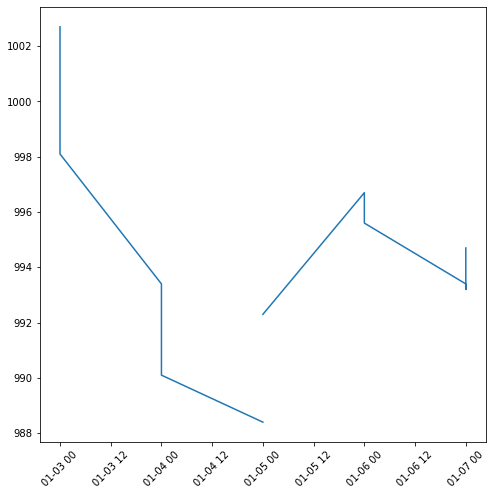

In [280]:
plot_value_series(lists_air_pressure[0], 'airPressure')

In [281]:
demo_list = lists_air_pressure[3].copy()

In [282]:
lists_air_pressure[1]

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     3    18  7     2009-01-18        992.7   94        10  -2.6   
                    14    2009-01-18        986.6   94        10  -3.4   
                    19    2009-01-18        982.9   95        10  -2.9   
           4    19  7     2009-01-19        986.6   75         4   2.4   
                    14    2009-01-19        981.2   53         7   6.3   
                    19    2009-01-19        977.5   87         5   2.4   
                20  7     2009-01-20        973.4   93        10   2.6   
                    14    2009-01-20        976.0   65        10   5.9   
                    19    2009-01-20          NaN   83         8   3.6   
                21  7     2009-01-21        978.8   92        10   3.2   
                    14    2009-01-21        980.8   83        10   4.4   
                    19    2009-01-21        982.6   92        10   2.2   
                22  7     2009-01-22        984.4   92        10   1.9   
                    14    2009-01-22        982.2   76         8   4.0   
                    19    2009-01-22        980.4   92         1   0.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     3    18  7              1       S  
                    14             3      SE  
                    19             2      SE  
           4    19  7              3       W  
                    14             2      SE  
                    19             1      NE  
                20  7              2      SE  
                    14             2       W  
                    19             1       W  
                21  7              2      SE  
                    14             2      NW  
                    19             2       W  
                22  7              3       W  
                    14             2       N  
                    19             1      NW

In [283]:
missing_temp_df_list = get_data_around_missing(df1, 'windDir')

In [263]:
missing_temp_df_list

[attributes                      date  airPressure  hum  skyCover  temp  \
 year month week day hours                                                
 2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                     14    2009-01-01        998.8   71         5  -0.1   
                     19    2009-01-01       1000.7   72        10  -1.8   
                 2   7     2009-01-02        999.6   67        10  -3.0   
                     14    2009-01-02        998.5   66         9  -1.3   
                     19    2009-01-02        999.8   68        10  -1.7   
                 3   7     2009-01-03       1002.7   83         3  -4.8   
                     14    2009-01-03       1000.0   70         5   NaN   
                     19    2009-01-03        998.1   70         1  -3.9   
                 4   7     2009-01-04        993.4   75         5  -3.8   
                     14    2009-01-04        991.0   62         9  -0.2   
                     19  

In [264]:
values = {}
for i in range(2009, 2022):
    value1 = df1.reset_index().groupby("year")["windDir"].value_counts().loc[i].index[0]
    value2 = df1.reset_index().groupby("year")["windDir"].value_counts().loc[i].index[1]

    vl1 = df1.reset_index().groupby("year")["windDir"].value_counts().loc[i].iloc[0]
    vl2 = df1.reset_index().groupby("year")["windDir"].value_counts().loc[i].iloc[1]

    values[i] = [{value1: vl1}, {value2: vl2}]
    

In [291]:
def clear_null(data):
    data_clean = data.copy()
    for col in data_clean.columns:
        if (np.issubdtype(data_clean[col].dtype, np.number) and col != "date"):
            data_clean[col] = data_clean[col].fillna(method="ffill") 
        if (col != "date" and np.issubdtype(data[col].dtype, np.number) == False):
            data_clean[col] = data_clean[col].replace(np.nan, df1["windDir"].mode().loc[0])
    
    return data_clean

In [292]:
cleaned_data = clear_null(df1)
cleaned_data

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0       W  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

In [293]:
df1

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0     NaN  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

In [294]:
df1["windDir"].mode().loc[0]

'W'

In [295]:
cleaned_data.reset_index()[cleaned_data.reset_index().temp >= 100].iloc[0]["temp"]

107.31549022289514

<AxesSubplot:xlabel='temp', ylabel='Count'>

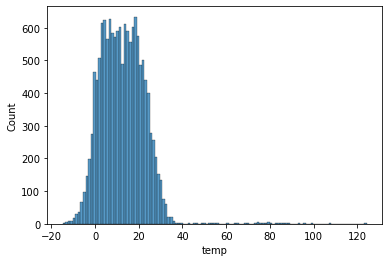

In [296]:
sns.histplot(cleaned_data.temp)

In [297]:
cleaned_data

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0       W  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

In [298]:
cleaned_data.reset_index()[cleaned_data.reset_index().temp >= 100].head(1).date + pd.DateOffset(1)

4709   2013-04-20
Name: date, dtype: datetime64[ns]

In [299]:
cleaned_data.reset_index()[cleaned_data.reset_index().temp >= 100].head(1)

attributes,year,month,week,day,hours,date,airPressure,hum,skyCover,temp,windBeauf,windDir
4709,2013,4,16,19,19,2013-04-19,994.7,93,10,107.31549,1,W


In [211]:
temps = cleaned_data[cleaned_data.temp < 45].temp.values

In [301]:
import random
random.choice(temps)

7.2

In [302]:
df_out_rem = cleaned_data.copy()

df_out_rem.temp = df_out_rem['temp'].where(df_out_rem['temp'] < 45, random.choice(temps))

<AxesSubplot:xlabel='temp', ylabel='Count'>

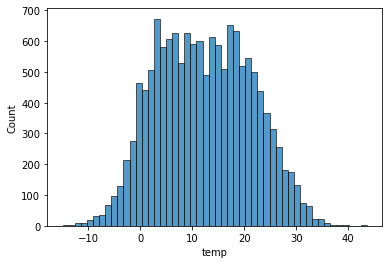

In [303]:
sns.histplot(df_out_rem.temp)

In [304]:
cleaned_data

attributes                      date  airPressure  hum  skyCover  temp  \
year month week day hours                                                
2009 1     1    1   7     2009-01-01        999.7   79        10  -4.5   
                    14    2009-01-01        998.8   71         5  -0.1   
                    19    2009-01-01       1000.7   72        10  -1.8   
                2   7     2009-01-02        999.6   67        10  -3.0   
                    14    2009-01-02        998.5   66         9  -1.3   
...                              ...          ...  ...       ...   ...   
2021 12    52   30  14    2021-12-30        993.3   88         8   9.5   
                    19    2021-12-30        995.1   97         9   7.2   
                31  7     2021-12-31        996.8   77         3  12.9   
                    14    2021-12-31        996.2   62         3  15.9   
                    19    2021-12-31        994.6   72         3  13.3   

attributes                 windBeauf windDir  
year month week day hours                     
2009 1     1    1   7              2       W  
                    14             2      NW  
                    19             2      NW  
                2   7              0       W  
                    14             2       W  
...                              ...     ...  
2021 12    52   30  14             1       E  
                    19             1      NE  
                31  7              4       W  
                    14             3      NW  
                    19             3       W  

[14244 rows x 7 columns]

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumtions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early October 2015 until mid March 2016)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumtion regarding the wind direction is true (errors only from SE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [305]:
selected_range = cleaned_data[(cleaned_data.date >= "2015-10-01") & (cleaned_data.date <= "2016-03-31")]
selected_range = selected_range.sort_values("date")

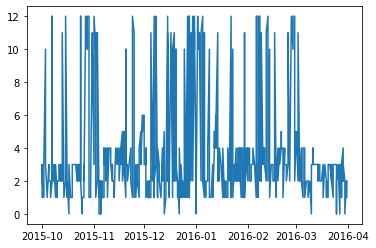

In [307]:
plt.plot(selected_range.date, selected_range.windBeauf)

<AxesSubplot:xlabel='windBeauf', ylabel='Count'>

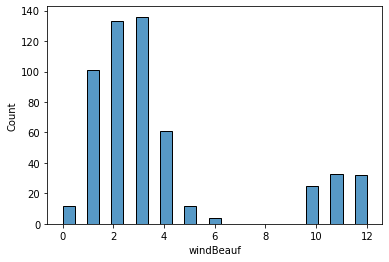

In [308]:
sns.histplot(selected_range.windBeauf)

In [310]:
selected_range.windDir.value_counts()

W     198
SE    102
NW     67
E      50
N      41
NE     34
S      33
SW     24
Name: windDir, dtype: int64

In [312]:
selected_range[(selected_range.windBeauf >= 6) & (selected_range.windBeauf <= 10)].windDir.value_counts()

SE    25
W      4
Name: windDir, dtype: int64

In [319]:
cleaned_data[cleaned_data.temp > 45].windDir.value_counts()

W     20
SE    12
NW     7
E      6
N      5
NE     4
S      4
Name: windDir, dtype: int64

In [338]:
df_without_se_out = cleaned_data[~cleaned_data.isin(selected_range[(selected_range.windBeauf >= 6) & (selected_range.windBeauf <= 10)])]

In [356]:
momnet = selected_range[(selected_range.windBeauf >= 6) & (selected_range.windBeauf <= 10)]

In [362]:
vals = np.array([2.7 for i in range(momnet.shape[0])])

In [363]:
momnet.windBeauf = vals

/tmp/ipykernel_1070/1121297779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  momnet.windBeauf = vals


In [412]:
non_numeric_values = set()
ls = []
nu = []
for v in df2.precip.unique():
    try:
        isinstance(float(v), float)
    except:
        non_numeric_values.add(v)

In [413]:
non_numeric_values

{'traces'}

15.3

In [423]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [424]:
df2

date precipType  precip
year month week day                              
2009 1     1    1   2009-01-01        NaN       0
                2   2009-01-02       snow  traces
                3   2009-01-03        NaN       0
                4   2009-01-04       snow  traces
           2    5   2009-01-05       snow  traces
...                        ...        ...     ...
2021 12    52   27  2021-12-27        NaN       0
                28  2021-12-28       rain     7.3
                29  2021-12-29       rain     1.9
                30  2021-12-30       rain     0.9
                31  2021-12-31       rain  traces

[4748 rows x 3 columns]